# Stage 2 — Target Construction

## Purpose

This stage constructs the **ground-truth target variables** that all downstream models will predict. Targets are derived directly from the `gameweeks` table in the FPL database and represent what actually happened in each gameweek.

The targets answer four distinct questions for each (player, gameweek) pair:
- **y_points**: How many FPL points did the player score?
- **y_play**: Did the player get any minutes? (binary)
- **y_60**: Did the player play 60+ minutes? (binary)
- **y_haul**: Did the player score 10+ points? (binary)

This stage does NOT create features. Targets are **what we predict**, not **what we use to predict**. The temporal contract is strict: predictions for gameweek $t$ can only use information from gameweeks $\leq t-1$.

## Inputs & Outputs

| Item | Description |
|------|-------------|
| **Input** | `gameweeks` table from `storage/fpl_2025_26.sqlite` |
| **Output** | `storage/datasets/targets.csv` |
| **Produced by** | `dugout.pipeline.targets` |
| **Status** | 🔒 Frozen, read-only |

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load frozen artifact
targets = pd.read_csv("../storage/datasets/targets.csv")

print(f"Rows: {len(targets):,}")
print(f"Players: {targets['player_id'].nunique()}")
print(f"Gameweeks: {targets['gw'].min()} to {targets['gw'].max()}")
targets.head()

Rows: 16,559
Players: 799
Gameweeks: 1 to 22


,player_id,gw,y_points,y_play,y_60,y_haul
0,1,1,10,1,1,1
1,1,2,6,1,1,0
2,1,3,2,1,1,0
3,1,4,6,1,1,0
4,1,5,2,1,1,0


## Structural Sanity Checks

In [2]:
# Uniqueness: (player_id, gw) must be unique
duplicates = targets.duplicated(subset=["player_id", "gw"]).sum()
print(f"Duplicate (player_id, gw) rows: {duplicates}")

# Missingness
print("\nMissing values per column:")
print(targets.isna().sum())

# Binary target validation
print("\nBinary target ranges:")
for col in ["y_play", "y_60", "y_haul"]:
    vals = targets[col].unique()
    print(f"  {col}: {sorted(vals)}")

Duplicate (player_id, gw) rows: 0

Missing values per column:
player_id    0
gw           0
y_points     0
y_play       0
y_60         0
y_haul       0
dtype: int64

Binary target ranges:
  y_play: [0, 1]
  y_60: [0, 1]
  y_haul: [0, 1]


In [3]:
# Target rates
print("Target base rates:")
print(f"  y_play (played any mins): {targets['y_play'].mean():.1%}")
print(f"  y_60 (played 60+ mins):   {targets['y_60'].mean():.1%}")
print(f"  y_haul (scored 10+ pts):  {targets['y_haul'].mean():.1%}")
print(f"\n  y_points mean: {targets['y_points'].mean():.2f}")
print(f"  y_points std:  {targets['y_points'].std():.2f}")

Target base rates:
  y_play (played any mins): 40.3%
  y_60 (played 60+ mins):   27.4%
  y_haul (scored 10+ pts):  1.8%

  y_points mean: 1.21
  y_points std:  2.41


## Distribution of Targets

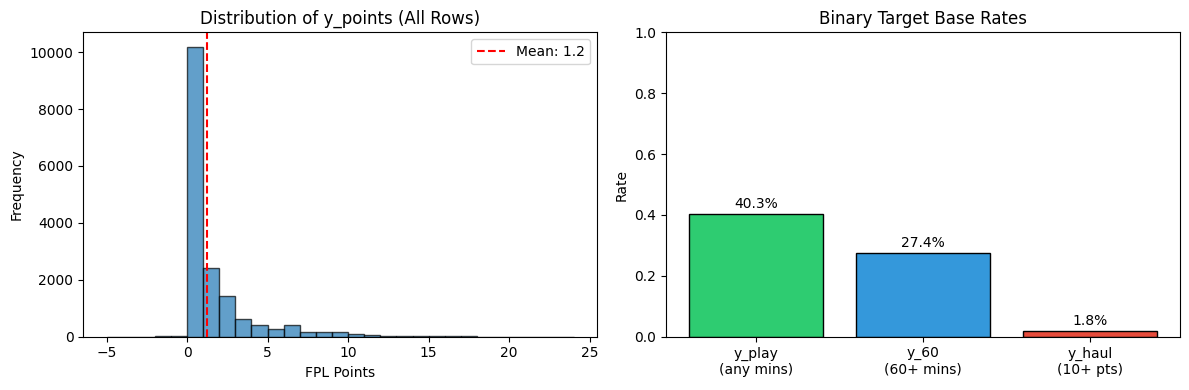

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Points distribution (all players)
axes[0].hist(targets["y_points"], bins=range(-5, 25), edgecolor="black", alpha=0.7)
axes[0].axvline(targets["y_points"].mean(), color="red", linestyle="--", label=f"Mean: {targets['y_points'].mean():.1f}")
axes[0].set_xlabel("FPL Points")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of y_points (All Rows)")
axes[0].legend()

# Binary target rates
rates = [targets["y_play"].mean(), targets["y_60"].mean(), targets["y_haul"].mean()]
labels = ["y_play\n(any mins)", "y_60\n(60+ mins)", "y_haul\n(10+ pts)"]
colors = ["#2ecc71", "#3498db", "#e74c3c"]
axes[1].bar(labels, rates, color=colors, edgecolor="black")
axes[1].set_ylabel("Rate")
axes[1].set_title("Binary Target Base Rates")
axes[1].set_ylim(0, 1)
for i, r in enumerate(rates):
    axes[1].text(i, r + 0.02, f"{r:.1%}", ha="center")

plt.tight_layout()
plt.show()

## Interpretation

### What the Numbers Mean

- **~40% play rate**: Most players in the FPL database are squad players who rarely feature. This is the core participation uncertainty.
- **~35% 60+ minute rate**: Among all player-gameweek rows, about a third involve full participation. The gap between y_play and y_60 represents rotation/substitution risk.
- **~2-3% haul rate**: Hauls (10+ points) are rare events — only occurring in ~2-3% of all rows. This is a highly imbalanced target.
- **Mean points ~1.5**: Pulled down by the majority of 0-point rows (non-players).

### The Temporal Contract

The critical rule: **targets are from gameweek $t$, features must be from gameweeks $\leq t-1$**.

This contract prevents data leakage. The pipeline enforces this by:
1. Constructing targets in a separate stage
2. Using `shift(1)` on all feature computations
3. Validating alignment in downstream stages

### Why Targets Are Immutable

Targets represent historical truth — they cannot change. Any re-run of Stage 2 on the same database will produce identical output. This is why the artifact is marked as frozen.

## What This Stage Enables

With ground-truth targets constructed and frozen, all downstream models have a stable prediction objective. The four targets support different use cases:

| Target | Downstream Use |
|--------|----------------|
| `y_play` | Participation probability model |
| `y_60` | Full-match probability model |
| `y_points` | Expected points regression |
| `y_haul` | Haul detection for differential picks |

All feature engineering and model training stages depend on these targets remaining unchanged.